In [2]:
%load_ext autoreload
%autoreload 2
import json
from scipy import sparse
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progress_bar
from collections import defaultdict
import string
import scipy.stats as stats

## Loading query lists

In [3]:
with open('queryTypeGlobal.json') as json_data:
    qTypeGlobal = json.load(json_data)

In [4]:
def loadJSON(sampleFilename):
    with open(sampleFilename) as json_data:
        sample_10000 = json.load(json_data)
    return sample_10000

In [45]:
# Sample 10000 A
sample_10000_A = loadJSON("sample-v2-10000-A.txt")

In [46]:
# Sample 10000 B
sample_10000_B = loadJSON("sample-v2-10000-B.txt")

In [47]:
# Sample 10000 C
sample_10000_C = loadJSON("sample-v2-10000-C.txt")

In [48]:
# Sample 10000 D
sample_10000_D = loadJSON("sample-v2-10000-D.txt")

In [49]:
len(set(sample_10000_C) & set(sample_10000_D))

print(sample_10000_A[:10])

[32805, 343102, 666213, 929213, 281028, 418473, 587272, 648286, 175840, 807055]


# How we do it

#### Scoring functions to evaluate:
    - BM25 
    - BM25P10-top5-idf 
    - BM25P10-top5-tfidf 
    - BM25P10-top10-idf 
    - BM25P10-top10-tfidf

For each scoring function result file we evaluate the 4 query types (A,B,C and D). We have some intermediate files from which we read the position of the corrent doc match. We evaluate if in top 1,10,100.

What are the metrics we are interested in?
- Win/loss ratio
- Average rank
- Precision @ 1,10,100
- MRR

There might be some queries in the input files with no results

## Metrics

In [5]:
def averageRank(rank_list):
    return np.mean(rank_list)

In [6]:
def winLossRatio(rank_list, interval = [0,1]):
    correct_class = [r for r in rank_list if r >= interval[0] and r < interval[1]]
#     print(len(correct_class),len(rank_list))
    if len(correct_class) == len(rank_list): return "-"
    else: return len(correct_class)/(len(rank_list) - len(correct_class))

In [7]:
def precision(rank, at=10):
    n_rel_retrieved = 0
    if rank <= at:
        n_rel_retrieved = 1
    return n_rel_retrieved/at

In [8]:
def avgPrecision(rank_list, at=1):
    prec_list = [precision(r, at) for r in rank_list]
    return np.mean(prec_list)

In [9]:
def MRR(rank_list, at=None):
    if at is not None:
        inverse_ranks = [1./x for x in rank_list if x <= at]
    else:
        inverse_ranks = [1./x for x in rank_list]
#     print(len(rank_list))
    return np.mean(inverse_ranks)

In [10]:
def RR(rank_list, at=None):
    if at is not None:
        inverse_ranks = [1./x for x in rank_list if x <= at]
    else:
        inverse_ranks = [1./x for x in rank_list]
#     print(len(rank_list))
    return inverse_ranks

In [11]:
### http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-24.html

In [12]:
def two_sample_ttest_ind(a,b):
    return stats.ttest_ind(a, b, equal_var=False)

In [13]:
def paired_ttest_in_time(a, b):
    return stats.ttest_reltest_rel(a, b)

In [14]:
intervals = [[0,1], [1,10], [10,100], [100,1000]]

def getMetrics(ranks, positions, interval):
    print("Avg. rank:", averageRank(ranks))
    print("Win/loss", winLossRatio(positions, interval))
    print("Avg. P@1", avgPrecision(ranks, at=1))
    print("Avg. P@10", avgPrecision(ranks, at=10))
    print("Avg. P@100", avgPrecision(ranks, at=100))
    print("Avg. P@1000", avgPrecision(ranks, at=1000))
    print("MRR", MRR(ranks))

# EVAL 

In [15]:
queryTypes = ["A", "B", "C", "D"]
queryHardness = ["E", "M", "H"]

In [16]:
def getQueryTypeSets(positions):
    A = [x for x in positions if x==0]
    B = [x for x in positions if x>0 and x<10]
    C = [x for x in positions if x>=10 and x<100]
    D = [x for x in positions if x>=100 and x<1000]
    print("A",len(A))
    print("B", len(B))
    print("C",len(C))
    print("D", len(D))

In [17]:
def getQueryTypeSetsInline(positions):
    A = [x for x in positions if x==0]
    B = [x for x in positions if x>0 and x<10]
    C = [x for x in positions if x>=10 and x<100]
    D = [x for x in positions if x>=100 and x<1000]
#     return " , ".join([str(len(A)),str(len(B)),str(len(C)), str(len(D)), str(10000-len(A) -len(B)-len(C)-len(D))])
    return len(A), len(B), len(C), len(D)


### BM25

In [18]:
def evalBM25(filename, qt):
    Bm25queryRankDict = loadJSON(filename)

    positions = list(Bm25queryRankDict.values())
    ranks = [x+1 for x in positions]
#     getMetrics(ranks, positions, interval=intervals[queryTypes.index(qt)])

    getMetrics(ranks, positions, interval=intervals[queryTypes.index(qt)])
    getQueryTypeSets(positions)

    #get some data
    bm25_mrr = MRR(ranks)
    bm25_avg_ranks = np.mean(ranks)
    bm25_query_class = getQueryTypeSetsInline(positions)

    return bm25_mrr, bm25_avg_ranks, bm25_query_class

In [20]:
hardness_bm25_holder = dict()

for qh in queryHardness:
    print(qh)
    bm25_mrr_dict = dict()
    bm25_avg_rank_dict = dict()
    for qt in queryTypes:
        print(qt)
        filename = "TerrierOuput-grid-search-alpha-p/eval/BM25P-signal-bm25-plain-sample-"+qh+"1000-"+qt+"-p-10-alpha-0.txt"
        print(filename)
        bm25_mrr, bm25_avg_ranks, bm25_query_class = evalBM25(filename, qt)
        bm25_mrr_dict[("bm25-plain", qt)] = bm25_mrr
        bm25_avg_rank_dict[("bm25-plain", qt)] = bm25_avg_ranks
        print()
    hardness_bm25_holder[qh] = (bm25_mrr_dict, bm25_avg_rank_dict)

E
A
TerrierOuput-grid-search-alpha-p/eval/BM25P-signal-bm25-plain-sample-E1000-A-p-10-alpha-0.txt
Avg. rank: 1.0
Win/loss -
Avg. P@1 1.0
Avg. P@10 0.10000000000000002
Avg. P@100 0.01
Avg. P@1000 0.0010000000000000005
MRR 1.0
A 1000
B 0
C 0
D 0

B
TerrierOuput-grid-search-alpha-p/eval/BM25P-signal-bm25-plain-sample-E1000-B-p-10-alpha-0.txt
Avg. rank: 3.975
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.10000000000000002
Avg. P@100 0.01
Avg. P@1000 0.0010000000000000005
MRR 0.3240496031746032
A 0
B 1000
C 0
D 0

C
TerrierOuput-grid-search-alpha-p/eval/BM25P-signal-bm25-plain-sample-E1000-C-p-10-alpha-0.txt
Avg. rank: 35.621
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.0
Avg. P@100 0.01
Avg. P@1000 0.0010000000000000005
MRR 0.04124352949059795
A 0
B 0
C 1000
D 0

D
TerrierOuput-grid-search-alpha-p/eval/BM25P-signal-bm25-plain-sample-E1000-D-p-10-alpha-0.txt
Avg. rank: 380.823
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.0
Avg. P@100 0.0
Avg. P@1000 0.0010000000000000005
MRR 0.0038671600923539337
A 0
B 0
C 0
D 1000

M

In [21]:
for k, (bm25_mrr_dict, bm25_avg_rank_dict) in hardness_bm25_holder.items():
    print("Hardness: " , k)
    print("MRR: ", bm25_mrr_dict)
    print("Avg. Rank: ", np.mean(list(bm25_avg_rank_dict.values())))
    print("Avg. Rank per group: ", bm25_avg_rank_dict)
    print()

Hardness:  E
MRR:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 0.3240496031746032, ('bm25-plain', 'C'): 0.04124352949059795, ('bm25-plain', 'D'): 0.0038671600923539337}
Avg. Rank:  105.35475
Avg. Rank per group:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 3.975, ('bm25-plain', 'C'): 35.621, ('bm25-plain', 'D'): 380.823}

Hardness:  M
MRR:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 0.3204742063492063, ('bm25-plain', 'C'): 0.04370681717449538, ('bm25-plain', 'D'): 0.004122975224381471}
Avg. Rank:  98.416
Avg. Rank per group:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 4.031, ('bm25-plain', 'C'): 33.24, ('bm25-plain', 'D'): 355.393}

Hardness:  H
MRR:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 0.31992103174603176, ('bm25-plain', 'C'): 0.04149711480073939, ('bm25-plain', 'D'): 0.004007788792159359}
Avg. Rank:  101.44075
Avg. Rank per group:  {('bm25-plain', 'A'): 1.0, ('bm25-plain', 'B'): 4.012, ('bm25-plain', 'C'): 34.928, ('bm25-plain', 'D'): 365.823}



### BM25P 

In [22]:
# Settings
dirEval = "./TerrierOuput-grid-search-alpha-p/eval/"
baseTypes = ["top5-idf", 
             "top5-tfidf",
             "top10-idf",
             "top10-tfidf"]
queryTypes = ["A", "B","C", "D"]
ending = ".txt" # sometimes res
queryHardness = ["E", "M", "H"]

### MRR plots for different alpha

In [24]:
import os

def get_stats_by_hardness(hardness):
    mrr_dict = defaultdict(list)
    rr_dict = defaultdict(list)
    average_rank_dict = defaultdict(list)

    for filename in os.listdir(dirEval):
        name_items = filename.split("-")
    #     print(name_items)
        if name_items[5] == hardness+"1000": 
            baseType = name_items[2]+"-"+name_items[3]
            alpha = filename.split(".")[0].split("-")[10]


            queryRankDict = loadJSON(dirEval+filename)
            positions = list(queryRankDict.values())
            ranks = [x+1 for x in positions]
            mrr_dict[(baseType, name_items[6])].append(((int(alpha)), MRR(ranks)))
            rr_dict[(baseType, name_items[6])].append(((int(alpha)), RR(ranks)))
            average_rank_dict[(baseType, name_items[6])].append(((int(alpha)), np.mean(ranks)))
    return mrr_dict, rr_dict, average_rank_dict

In [25]:
def plot_and_sort(baseType, mrr_dict, bm25_mrr_dict, queryTypes):
    for queryType in queryTypes:
        key = (baseType, queryType)
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
#         print(x)
#         print(y)
        plt.plot(x,y , label=key)
        #print(max(y),x[y.index(max(y))])
        plt.plot(x[y.index(max(y))], max(y), "or")
        # print bm25 as baseline
        baseline_y = [bm25_mrr_dict[("bm25-plain", queryType)]] * len(x)
#         print(baseline_y)
        plt.plot(x, baseline_y, label="('bm25-plain', " + str(queryType)+ "')", linestyle="--")
#         print()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("BM25P varying alpha")
    plt.xlabel("Alpha")
    plt.ylabel("MRR@1000")
#     plt.axis([5,25,0,20]) # this is for zooming in
    plt.show()
    return plt

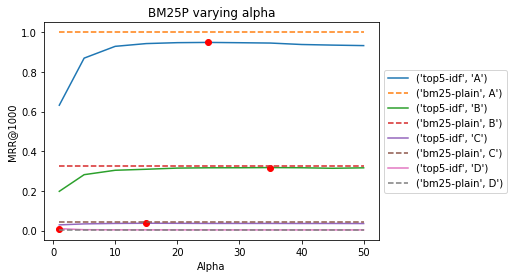

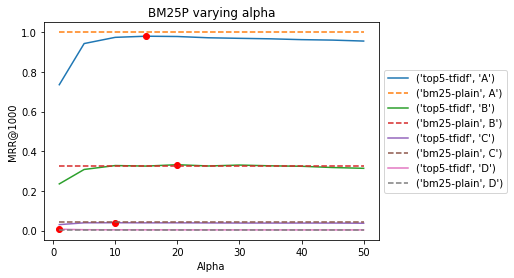

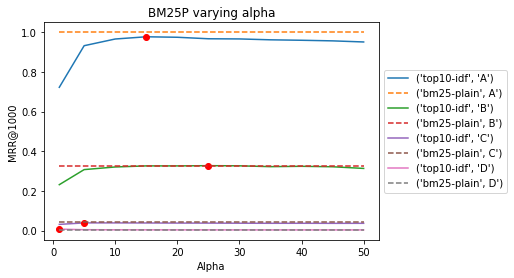

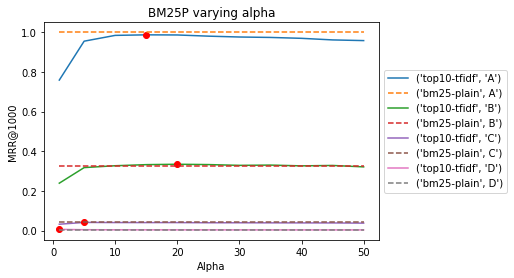

In [26]:
bm25_mrr_dict = hardness_bm25_holder["E"][0]
mrr_dict, rr_dict, average_rank_dict = get_stats_by_hardness("E")

for baseType in baseTypes:
    plot_and_sort(baseType, mrr_dict, bm25_mrr_dict, queryTypes)

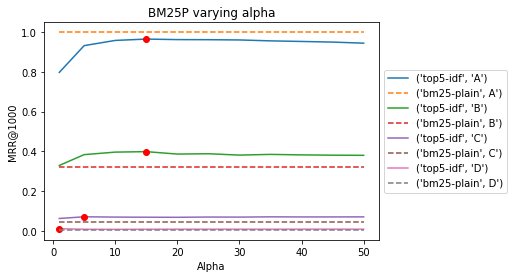

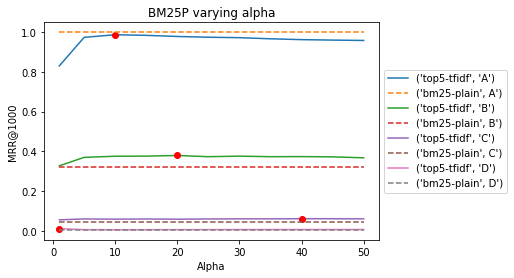

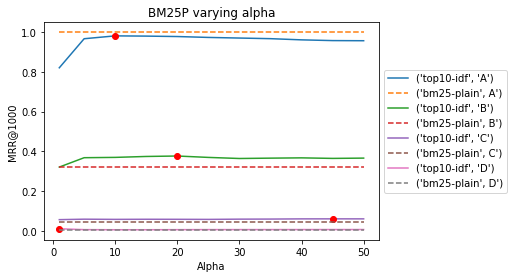

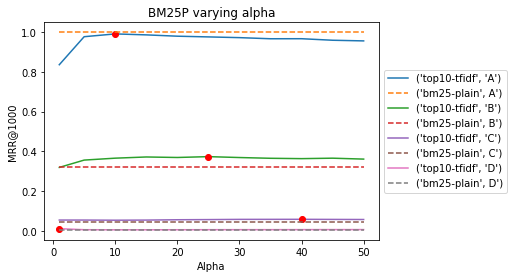

In [28]:
bm25_mrr_dict = hardness_bm25_holder["M"][0]
mrr_dict, rr_dict, average_rank_dict = get_stats_by_hardness("M")

for baseType in baseTypes:
    plot_and_sort(baseType, mrr_dict, bm25_mrr_dict, queryTypes)

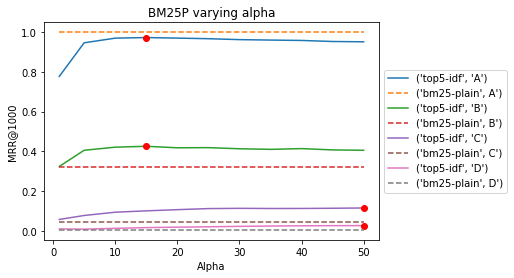

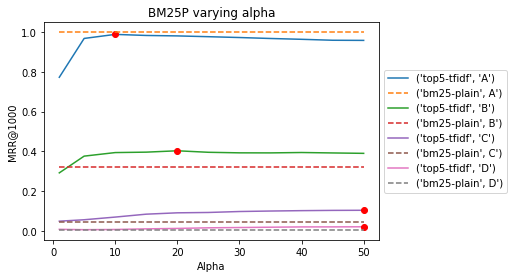

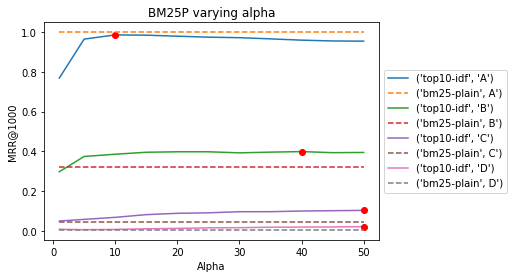

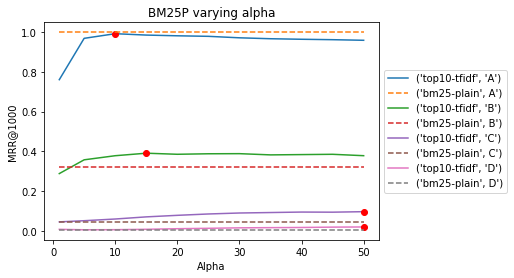

In [29]:
bm25_mrr_dict = hardness_bm25_holder["H"][0]
mrr_dict, rr_dict, average_rank_dict = get_stats_by_hardness("H")

for baseType in baseTypes:
    plot_and_sort(baseType, mrr_dict, bm25_mrr_dict, queryTypes)

# Average rank

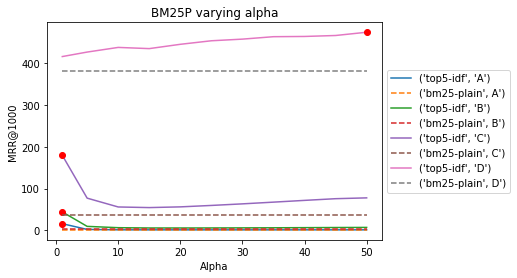

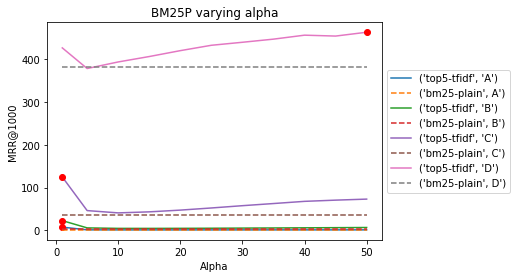

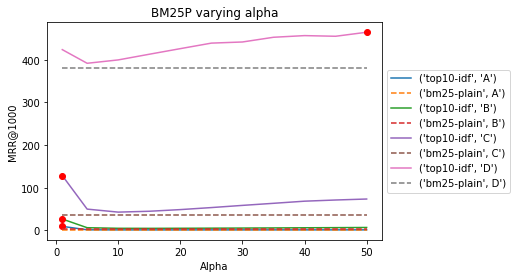

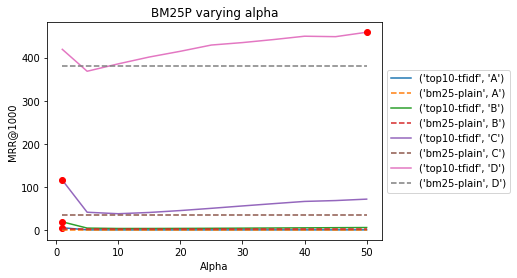

In [36]:
bm25_avg_rank_dict = hardness_bm25_holder["E"][1]
mrr_dict, rr_dict, average_rank_dict = get_stats_by_hardness("E")

for baseType in baseTypes:
    a = plot_and_sort(baseType, average_rank_dict, bm25_avg_rank_dict, queryTypes)

In [37]:
for baseType in baseTypes:

    for queryType in queryTypes:
        key = (baseType, queryType)
        avg_rank_list = average_rank_dict[key]
        x = [x for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]

        avg_rank_bm25 = bm25_avg_rank_dict[("bm25-plain", queryType)]
        #for i in range(len(y)):
        for i in [2,3,4,5,6]:
            
            print("\x1b[0m "+str(key), x[i], y[i], avg_rank_bm25, end='')
            print("\x1b[31m WIN" if y[i]<avg_rank_bm25 else "\x1b[0m ") 
        print()
        
    print("--------------------------------")

 ('top5-idf', 'A') 10 1.273 1.0 
 ('top5-idf', 'A') 15 1.178 1.0 
 ('top5-idf', 'A') 20 1.16 1.0 
 ('top5-idf', 'A') 25 1.157 1.0 
 ('top5-idf', 'A') 30 1.167 1.0 

 ('top5-idf', 'B') 10 6.324 3.975 
 ('top5-idf', 'B') 15 5.647 3.975 
 ('top5-idf', 'B') 20 5.615 3.975 
 ('top5-idf', 'B') 25 5.721 3.975 
 ('top5-idf', 'B') 30 5.909 3.975 

 ('top5-idf', 'C') 10 55.922 35.621 
 ('top5-idf', 'C') 15 54.45 35.621 
 ('top5-idf', 'C') 20 56.154 35.621 
 ('top5-idf', 'C') 25 59.587 35.621 
 ('top5-idf', 'C') 30 63.363 35.621 

 ('top5-idf', 'D') 10 437.8281068524971 380.823 
 ('top5-idf', 'D') 15 434.9605734767025 380.823 
 ('top5-idf', 'D') 20 445.2677261613692 380.823 
 ('top5-idf', 'D') 25 453.72830188679245 380.823 
 ('top5-idf', 'D') 30 457.66579973992197 380.823 

--------------------------------
 ('top5-tfidf', 'A') 10 1.058 1.0 
 ('top5-tfidf', 'A') 15 1.047 1.0 
 ('top5-tfidf', 'A') 20 1.05 1.0 
 ('top5-tfidf', 'A') 25 1.07 1.0 
 ('top5-tfidf', 'A') 30 1.082 1.0 

 ('top5-tfidf', 'B'

In [38]:
print("BM25 avg rank :", np.mean(list(bm25_avg_rank_dict.values())))

for baseType in baseTypes:
    all_avg_rank = np.zeros(11)
    for queryType in queryTypes:
        key = (baseType, queryType)
#         print(key)
        avg_rank_list = average_rank_dict[key]
        x = [x for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        all_avg_rank += np.array(y)
#         print(x)
#         print(y)
#         print(all_avg_rank)
    print()
    print(baseType+ " avg rank[1-50] : ", all_avg_rank/4)

BM25 avg rank : 105.35475

top5-idf avg rank[1-50] :  [163.86391278 128.84664501 125.33677671 124.05889337 127.04918154
 130.04832547 132.02619993 134.5615     135.84141128 137.50860755
 140.01330177]

top5-tfidf avg rank[1-50] :  [145.3559263  107.84978629 110.02176316 113.77918688 118.27178472
 122.71662952 125.89789447 129.06521304 132.75303884 133.02751662
 135.96674003]

top10-idf avg rank[1-50] :  [147.07299039 112.29901923 112.11989973 115.90886607 120.21219208
 124.70522733 126.71828232 130.79242834 133.10021113 133.4883869
 136.52754029]

top10-tfidf avg rank[1-50] :  [140.29128735 104.16251871 107.31759006 112.01683806 116.48211468
 121.46588111 124.34109051 127.51561757 130.83478785 131.17050649
 134.65243936]


### Statistical significance for MRR values

In [30]:
print(rr_dict.keys())

dict_keys([('top5-idf', 'B'), ('top5-tfidf', 'A'), ('top10-tfidf', 'A'), ('top10-tfidf', 'C'), ('top5-tfidf', 'D'), ('top10-idf', 'D'), ('top5-tfidf', 'C'), ('top5-idf', 'C'), ('top10-idf', 'A'), ('top5-idf', 'A'), ('top10-tfidf', 'B'), ('top10-tfidf', 'D'), ('top5-tfidf', 'B'), ('top10-idf', 'B'), ('top10-idf', 'C'), ('top5-idf', 'D')])


In [31]:
def check_statistical_significance(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
        
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        max_index = x[y.index(max(y))]
        
        for first, second in zip(sorted_rr_list, sorted_rr_list[1:]):
            print(first[0], second[0])
            print(y[x.index(first[0])], y[x.index(second[0])])
            print(two_sample_ttest_ind(first[1], second[1]))

In [32]:
def check_statistical_significance_with_max(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
        
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        max_alpha = x[y.index(max(y))]
        print(max_alpha)
        max_rrs = sorted_rr_list[x.index(max_alpha)][1]
        
        for first in sorted_rr_list:
            print(first[0], max_alpha)
            print(y[x.index(first[0])], y[x.index(max_alpha)])
            print(two_sample_ttest_ind(first[1], max_rrs))

In [ ]:
check_statistical_significance_with_max('top5-idf', rr_dict, mrr_dict, queryTypes)

In [52]:
for baseType in baseTypes:
    check_statistical_significance_with_max(baseType, rr_dict, mrr_dict, queryTypes)

('top5-idf', 'A')
20
1 20
0.730923639428 0.958864261523
Ttest_indResult(statistic=-55.590879755704215, pvalue=0.0)
5 20
0.917882274567 0.958864261523
Ttest_indResult(statistic=-15.278477541175882, pvalue=2.28788795818835e-52)
10 20
0.95221213023 0.958864261523
Ttest_indResult(statistic=-2.9500677170632748, pvalue=0.0031807493760989706)
15 20
0.958245889011 0.958864261523
Ttest_indResult(statistic=-0.28555268151024893, pvalue=0.77522370713241706)
20 20
0.958864261523 0.958864261523
Ttest_indResult(statistic=0.0, pvalue=1.0)
25 20
0.95790752766 0.958864261523
Ttest_indResult(statistic=-0.4388107946985173, pvalue=0.6608033803744856)
30 20
0.955453672596 0.958864261523
Ttest_indResult(statistic=-1.5359885705964829, pvalue=0.12455705136270427)
35 20
0.952865271577 0.958864261523
Ttest_indResult(statistic=-2.6537372636280949, pvalue=0.0079669220664925679)
40 20
0.94993465556 0.958864261523
Ttest_indResult(statistic=-3.8743784089152231, pvalue=0.00010724308472020827)
45 20
0.947155010378 0.95

('top10-tfidf', 'D')
50
1 50
0.00696927588881 0.0115306472763
Ttest_indResult(statistic=-6.5970625395749929, pvalue=4.3788460172353841e-11)
5 50
0.00478955007925 0.0115306472763
Ttest_indResult(statistic=-10.744817965278511, pvalue=9.4575939572518953e-27)
10 50
0.00470967390063 0.0115306472763
Ttest_indResult(statistic=-10.873162012329589, pvalue=2.381588786253388e-27)
15 50
0.00539194624935 0.0115306472763
Ttest_indResult(statistic=-9.653981172067617, pvalue=6.106505039768343e-22)
20 50
0.00655241437106 0.0115306472763
Ttest_indResult(statistic=-7.4873072712917095, pvalue=7.6142300916803523e-14)
25 50
0.00789730042527 0.0115306472763
Ttest_indResult(statistic=-5.0152144787571142, pvalue=5.3664832929591917e-07)
30 50
0.00884112145771 0.0115306472763
Ttest_indResult(statistic=-3.5322567955659188, pvalue=0.00041330068310784656)
35 50
0.00967505919843 0.0115306472763
Ttest_indResult(statistic=-2.3199733214833969, pvalue=0.020355142876243796)
40 50
0.0103141068265 0.0115306472763
Ttest_ind

### WIN/LOSS ratio for varying alpha

In [53]:
import os

class_dict = defaultdict(list)
for filename in os.listdir(dirEval):
    name_items = filename.split("-")
    baseType = name_items[2]+"-"+name_items[3]
    alpha = filename.split(".")[0].split("-")[10]
    
    queryRankDict = loadJSON(dirEval+filename)
    positions = list(queryRankDict.values())
    ranks = [x+1 for x in positions]
    new_class = getQueryTypeSetsInline(positions)
    class_dict[(baseType, name_items[6])].append(((int(alpha)), new_class))

In [54]:
def getWinLossRatio(baseType, queryType, alpha, class_dict):
    line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
    if queryType == "A":
        losses = sum(line[1][1:])
        wins = []
        for queryType in ["B","C","D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][0])
        return sum(wins)/losses
    if queryType == "B":
        losses = sum(line[1][2:])
        wins = []
        for queryType in ["C","D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][1])
        return sum(wins)/losses
    if queryType == "C":
        losses = sum(line[1][3:])
        wins = []
        for queryType in ["D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][2])
        return sum(wins)/losses
        

In [55]:
getWinLossRatio("top5-tfidf", "C", 10, class_dict)

3.682730923694779

In [56]:
win_loss_dict = defaultdict(list) ### the list contains WL for multiple alpha

for baseType in baseTypes:
    for queryType in queryTypes:
        if queryType is not "D":
            for alpha,_ in class_dict[(baseType, queryType)]:
                wl = getWinLossRatio(baseType, queryType, alpha, class_dict)
                win_loss_dict[(baseType, queryType)].append(((int(alpha)), wl))

In [57]:
print(win_loss_dict)

defaultdict(<class 'list'>, {('top5-idf', 'A'): [(15, 1.639777468706537), (5, 0.847758887171561), (30, 1.7476510067114095), (50, 1.4871220604703248), (40, 1.6136919315403424), (20, 1.747175141242938), (35, 1.6765083440308088), (45, 1.5134502923976607), (25, 1.7745098039215685), (10, 1.432129514321295), (1, 0.25191055759977354)], ('top5-idf', 'B'): [(10, 2.2531645569620253), (20, 2.6043276661514683), (30, 2.2433510638297873), (1, 0.35560344827586204), (45, 1.8280739934711643), (50, 1.7437759336099585), (35, 2.0754017305315204), (5, 1.361266294227188), (15, 2.561622464898596), (40, 1.962920046349942), (25, 2.4644412191582004)], ('top5-idf', 'C'): [(20, 1.4252747252747253), (1, 0.38395316804407714), (35, 0.9633867276887872), (40, 0.9038461538461539), (30, 1.060884070058382), (45, 0.8442513368983957), (5, 1.0517241379310345), (50, 0.8003814367450731), (25, 1.2282398452611218), (15, 1.6354799513973268), (10, 1.58675799086758)], ('top5-tfidf', 'A'): [(30, 1.819672131147541), (45, 1.514285714

In [60]:
def plot_and_sort_WL(baseType, win_loss_dict, queryTypes):
    for queryType in ["A","B","C"]:
        key = (baseType, queryType)
        wl_list = win_loss_dict[key]
#         print(key)
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(wl_list, key=lambda tup: tup[0])]
#         print(x)
        y = [y for x,y in sorted(wl_list, key=lambda tup: tup[0])]
#         print(y)
        plt.plot(x, y , label=key)
        #print(max(y),x[y.index(max(y))])
        plt.plot(x[y.index(max(y))], max(y), "or")
    plt.plot(x, [1 for x in range(len(x))], ":k", label="win-loss threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("BM25P varying alpha")
    plt.xlabel("Alpha")
    plt.ylabel("WinLossRatio")
    plt.show()

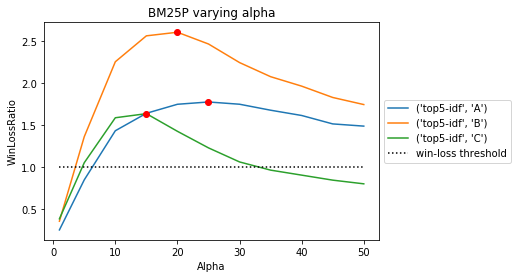

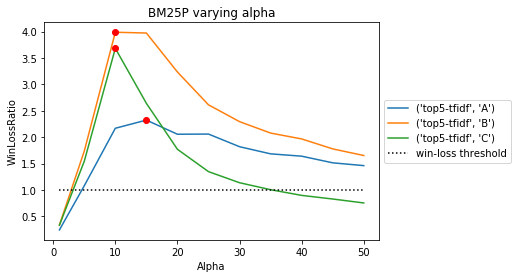

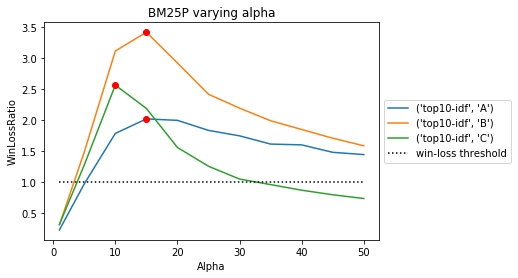

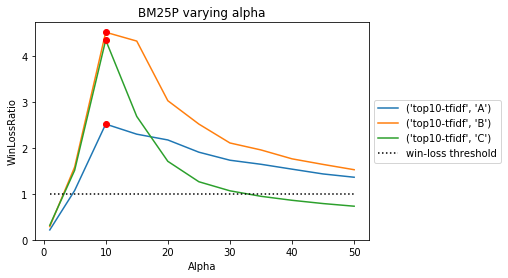

In [61]:
for baseType in baseTypes:
    plot_and_sort_WL(baseType, win_loss_dict, queryTypes)

## Todo:

- intersect qid from wins of C for alpha 10 with wins of C for alpha 40

# Average rank

In [78]:
for baseType in baseTypes:

    for queryType in queryTypes:
        key = (baseType, queryType)
        avg_rank_list = average_rank_dict[key]
        x = [x for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]

        avg_rank_bm25 = bm25_avg_rank_dict[("bm25-plain", queryType)]
        #for i in range(len(y)):
        for i in [2,3,4,5,6]:
            
            print("\x1b[0m "+str(key), x[i], y[i], avg_rank_bm25, end='')
            print("\x1b[31m WIN" if y[i]<avg_rank_bm25 else "\x1b[0m ") 
        print()
        
    print("--------------------------------")

 ('top5-idf', 'A') 10 1.1844 1.0 
 ('top5-idf', 'A') 15 1.1482 1.0 
 ('top5-idf', 'A') 20 1.1479 1.0 
 ('top5-idf', 'A') 25 1.1603 1.0 
 ('top5-idf', 'A') 30 1.1805 1.0 

 ('top5-idf', 'B') 10 4.756 3.9538 
 ('top5-idf', 'B') 15 4.5066 3.9538 
 ('top5-idf', 'B') 20 4.539 3.9538 
 ('top5-idf', 'B') 25 4.6673 3.9538 
 ('top5-idf', 'B') 30 4.8334 3.9538 

 ('top5-idf', 'C') 10 41.897489749 34.88 
 ('top5-idf', 'C') 15 40.2349 34.88 
 ('top5-idf', 'C') 20 41.797 34.88 
 ('top5-idf', 'C') 25 44.2254225423 34.88 
 ('top5-idf', 'C') 30 47.1514151415 34.88 

 ('top5-idf', 'D') 10 336.022608888 364.3362 WIN
 ('top5-idf', 'D') 15 342.638312049 364.3362 WIN
 ('top5-idf', 'D') 20 345.11172679 364.3362 WIN
 ('top5-idf', 'D') 25 347.874466367 364.3362 WIN
 ('top5-idf', 'D') 30 350.53006236 364.3362 WIN

--------------------------------
 ('top5-tfidf', 'A') 10 1.05 1.0 
 ('top5-tfidf', 'A') 15 1.0529 1.0 
 ('top5-tfidf', 'A') 20 1.0698 1.0 
 ('top5-tfidf', 'A') 25 1.0933 1.0 
 ('top5-tfidf', 'A') 30 

In [79]:
print("BM25 avg rank :", np.mean(list(bm25_avg_rank_dict.values())))

for baseType in baseTypes:
    all_avg_rank = np.zeros(11)
    for queryType in queryTypes:
        key = (baseType, queryType)
#         print(key)
        avg_rank_list = average_rank_dict[key]
        x = [x for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        all_avg_rank += np.array(y)
#         print(x)
#         print(y)
#         print(all_avg_rank)
    print()
    print(baseType+ " avg rank[1-50] : ", all_avg_rank/4)

BM25 avg rank : 101.0425

top5-idf avg rank[1-50] :  [ 128.42746399   98.08260837   95.96512466   97.13200301   98.1489067
   99.48187223  100.92384438  101.97980863  103.34284858  104.46345219
  105.35031563]

top5-tfidf avg rank[1-50] :  [ 126.32077761   94.13544004   93.42721615   95.05787653   96.88817467
   99.08935989  100.56059712  101.84956083  103.17281617  104.72638373
  106.00936307]

top10-idf avg rank[1-50] :  [ 128.4674109    96.08558583   94.80880798   96.1159823    97.66589093
   99.90374971  101.0684205   102.56772041  103.97405811  105.39633229
  106.42135897]

top10-tfidf avg rank[1-50] :  [ 126.59848471   95.07453703   94.4555784    95.99419318   97.31344145
   99.76657011  101.17928157  102.45338313  103.73403291  105.34587434
  106.80417351]
